<a href="https://colab.research.google.com/github/schokoro/cnn_crf_nertagger/blob/master/NER_tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN и CRF для извлечения именованных сущностей



In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    

Tesla T4


In [0]:
import sys
sys.path.append('/content/cnn_crf_nertagger')

In [3]:
!rm -rf cnn_crf_nertagger/
!git clone -b dev https://github.com/schokoro/cnn_crf_nertagger.git > /dev/null
!pip install allennlp wget youtokentome ipymarkup seqeval livelossplot> /dev/null


Cloning into 'cnn_crf_nertagger'...
remote: Enumerating objects: 279, done.
remote: Total 279 (delta 0), reused 0 (delta 0), pack-reused 279
Receiving objects: 100% (279/279), 269.93 KiB | 903.00 KiB/s, done.
Resolving deltas: 100% (139/139), done.


In [0]:
%load_ext autoreload
%autoreload 2

import spacy
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from allennlp.data.dataset_readers.conll2003 import Conll2003DatasetReader
from allennlp.common.util import ensure_list
# from allennlp.data.vocabulary import Vocabulary
from allennlp.training.metrics import SpanBasedF1Measure
from torch import nn
from torch.nn import functional as F
# from torch.utils.data import TensorDataset
from pdb import set_trace
from gc import collect
from tqdm.notebook import tqdm
import wget
from multiprocessing import cpu_count
import cnn_crf_nertagger
from cnn_crf_nertagger.modules.modules import NERTaggerModel, NERTagger
from cnn_crf_nertagger.utils.pipeline import train_eval_loop, predict_with_model
from cnn_crf_nertagger.utils.prepare import tag_corpus_to_tensor, tokenize_corpus, make_yttm_tokenizer, highlight_text, tensor_to_tags, ConllDataset
from os import path, listdir
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from seqeval.metrics import classification_report
sns.set()
%matplotlib inline

rcParams['figure.figsize'] = 12, 12
torch.backends.cudnn.deterministic=False 

## Подготовка данных




### Загружаем корпуса

In [5]:
!rm -fv /content/cnn_crf_nertagger/data/*


removed '/content/cnn_crf_nertagger/data/readme.txt'


In [0]:
path_data = '/content/cnn_crf_nertagger/data/'
path_train = '/content/cnn_crf_nertagger/data/eng.train'
path_valid = '/content/cnn_crf_nertagger/data/eng.testa'
path_test = '/content/cnn_crf_nertagger/data/eng.testb'

dataset_urls = {
    'eng.testa': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa',
    'eng.testb': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb',
    'eng.train': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train'}
for file_name in dataset_urls:
    wget.download(dataset_urls[file_name], path.join(path_data, file_name))

In [7]:
%%time
conll_reader = Conll2003DatasetReader()
train_conll = ensure_list(conll_reader.read(path_train))
valid_conll = ensure_list(conll_reader.read(path_valid))
test_conll = ensure_list(conll_reader.read(path_test))

14041it [00:01, 12064.66it/s]
3250it [00:00, 9329.59it/s]
3453it [00:00, 23297.45it/s]

CPU times: user 1.6 s, sys: 64.7 ms, total: 1.66 s
Wall time: 1.67 s


In [8]:
all_conll = train_conll + valid_conll + test_conll
len(all_conll), len(train_conll), len(valid_conll), len(test_conll)

(20744, 14041, 3250, 3453)

### Готовим словари соответсвия тег-id и bpe - токенизатор



In [9]:
tags = set()
tokens = set()

max_sent_len = 0
for instance in all_conll[: ]:
    if len(instance['tokens']) >  max_sent_len:
        max_sent_len = len(instance['tokens'])
    tags.update(instance['tags'])
    tokens.update(instance['tokens'])
    
print(f'Максимальная длина предложения: {max_sent_len} токенов')

Максимальная длина предложения: 124 токенов


In [10]:
%time bpe_tokenizer = make_yttm_tokenizer(train_conll, 400)

CPU times: user 151 ms, sys: 26.1 ms, total: 177 ms
Wall time: 129 ms


In [11]:
%%time
max_token_len = 0
for p in tqdm(range(101)):
    len_tokens = [len(bpe_tokenizer.encode(token.text, dropout_prob=p/100))  for token in tokens]
    if max(len_tokens) > max_token_len:
        p_dropout = .01 * p
        max_token_len = max(len_tokens)

print(f'Максимальная длина токена: {max_token_len} субтокенов при вероятности дропаута {p_dropout}')


Максимальная длина токена: 62 субтокенов при вероятности дропаута 0.12
CPU times: user 9.55 s, sys: 52.3 ms, total: 9.6 s
Wall time: 9.62 s


In [0]:
tag2id = {tag: num for num, tag in enumerate(['<NOTAG>'] + list(tags))}

В датасете присутствует очень мало тегов вида B-XXX. Попробуем чуть размножить предложения с этими тегами. Использование дропаута в bpe внесёт немного разнообразия в эти предложения.

In [13]:
%%time
BPE_DROPOUT = .25
train_dataset = ConllDataset(train_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len, 50, BPE_DROPOUT)
valid_dataset = ConllDataset(valid_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len)
test_dataset = ConllDataset(test_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len)


CPU times: user 16.4 ms, sys: 1.02 ms, total: 17.4 ms
Wall time: 17.4 ms


In [14]:
len(train_dataset), len(valid_dataset), len(test_dataset) 

(16641, 3250, 3453)

## Создаём и обучаем сеть

In [0]:
models_path = '/content/cnn_crf_nertagger/models/best_model.pth'

In [16]:
try:
    del model    
    collect()
except:
    print('no model')
finally:
    torch.cuda.empty_cache()


no model


Сеть состоит из двух однотипных свёрточных блоков и CRF. На первом уровне мы осуществляем свёртку над субтокенами и делаем глобал-пуллинг. Затем получившиеся эмбедденги токенов передаём на следующий свёрточный блок. Он значительно глубже, чтобы увеличить рецептивное поле. Выход второго блока передаём в CRF, который возвращает нам `log-likelihood`.

In [17]:
torch.cuda.empty_cache()
model = NERTaggerModel(len(bpe_tokenizer.vocab()), len(tag2id), tag2id, embedding_size=64,
                                              single_backbone_kwargs=dict(layers_n=3, kernel_size=3, dropout=0.2, dilation=[1, 1, 1]),
                                              context_backbone_kwargs=dict(layers_n=6, kernel_size=3, dropout=0.1, dilation=[1, 1, 1, 2, 2 , 2]))
print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

Количество параметров 137573


In [0]:
# try:
#     model.load_state_dict(torch.load(models_path))
# except:
#     print('no model')

In [0]:
losses = {}

In [20]:
(best_val_loss,
 best_model,
 losses) = train_eval_loop(
     model,
     train_dataset,
     valid_dataset,
     lr=5e-3,
     epoch_n=200,
     batch_size=128,
     device=device,
     early_stopping_patience=8,
     l2_reg_alpha = 1e-6,
     max_batches_per_epoch_train=100,
     max_batches_per_epoch_val=100,
     dataloader_workers_n=cpu_count(),
     lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(
         optim, patience=4,
         factor=0.1,
         threshold=1e-2,
         verbose=True,
         min_lr=1e-6),
     verbose_batch=False,
     verbose_liveloss=False,
     prev_loss=losses
    )
 
torch.save(best_model.state_dict(), models_path)

Эпоха 0
Эпоха: 101 итераций, 30.91 сек
Среднее значение функции потерь на обучении 11.36880344447523
Среднее значение функции потерь на валидации 4.04580171750142
Новая лучшая модель!

Эпоха 1
Эпоха: 101 итераций, 31.02 сек
Среднее значение функции потерь на обучении 3.347749601496328
Среднее значение функции потерь на валидации 2.6678824791541467
Новая лучшая модель!

Эпоха 2
Эпоха: 101 итераций, 30.86 сек
Среднее значение функции потерь на обучении 2.3184441941799503
Среднее значение функции потерь на валидации 2.098507949939141
Новая лучшая модель!

Эпоха 3
Эпоха: 101 итераций, 30.96 сек
Среднее значение функции потерь на обучении 1.8628094597618179
Среднее значение функции потерь на валидации 1.7882237571936388
Новая лучшая модель!

Эпоха 4
Эпоха: 101 итераций, 30.90 сек
Среднее значение функции потерь на обучении 1.6235405419132498
Среднее значение функции потерь на валидации 1.6183608621358871
Новая лучшая модель!

Эпоха 5
Эпоха: 101 итераций, 30.95 сек
Среднее значение функции п

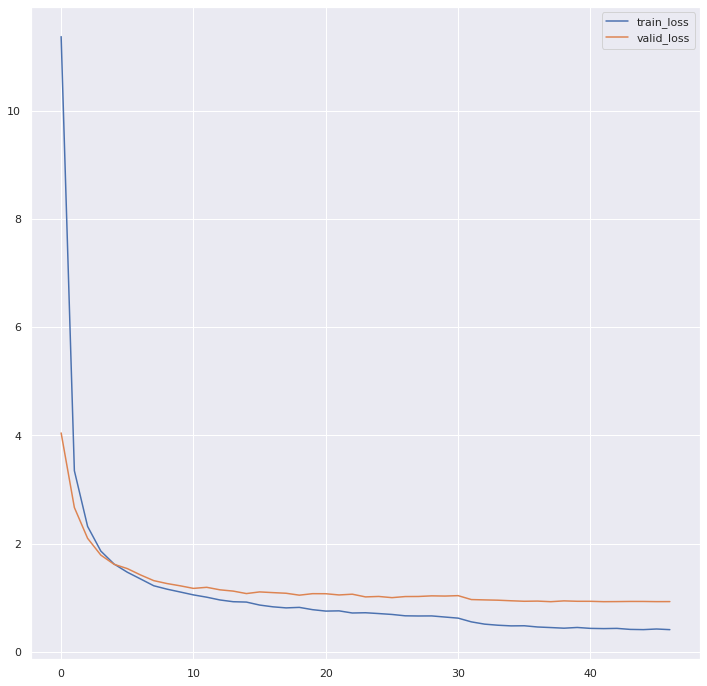

In [21]:
pd.DataFrame(losses).plot();

In [22]:
model.load_state_dict(torch.load(models_path))

<All keys matched successfully>

## Проверки

In [0]:
id2tag = {item[1]: item[0] for item in tag2id.items()}
UNIQUE_TAGS = [id2tag[i] for i in range(len(tag2id))]


### Проверка - train

In [24]:
%%time 
train_targets = [item[1] for item in train_dataset]
train_targets = torch.stack(train_targets)
train_targets.shape

CPU times: user 7.09 s, sys: 48.4 ms, total: 7.14 s
Wall time: 7.15 s


In [25]:
train_pred = predict_with_model(model, train_dataset)
train_golden_tags = tensor_to_tags(train_targets, id2tag)
train_pred_tags = tensor_to_tags(train_pred, id2tag)
print(classification_report(train_golden_tags, train_pred_tags, digits=4))
print(classification_report(train_golden_tags, train_pred_tags, digits=4, suffix=True))


521it [00:28, 17.99it/s]                               


           precision    recall  f1-score   support

      PER     0.9437    0.9687    0.9560      7250
      LOC     0.9076    0.9049    0.9063      9540
      ORG     0.9081    0.8121    0.8574      8521
     MISC     0.8571    0.8152    0.8357      7588

micro avg     0.9047    0.8743    0.8892     32899
macro avg     0.9041    0.8743    0.8883     32899

           precision    recall  f1-score   support

        I     0.9262    0.9579    0.9418     30278
        B     0.7567    0.6460    0.6970      2754

micro avg     0.9143    0.9319    0.9230     33032
macro avg     0.9120    0.9319    0.9214     33032



### Проверка - valid

In [26]:
%%time 
valid_targets = [item[1] for item in valid_dataset]
valid_targets = torch.stack(valid_targets)
valid_targets.shape

CPU times: user 1.24 s, sys: 6.99 ms, total: 1.25 s
Wall time: 1.25 s


In [27]:
valid_pred = predict_with_model(model, valid_dataset)

 
valid_golden_tags = tensor_to_tags(valid_targets, id2tag)
valid_pred_tags = tensor_to_tags(valid_pred, id2tag)
print(classification_report(valid_golden_tags, valid_pred_tags, digits=4))
print(classification_report(valid_golden_tags, valid_pred_tags, digits=4, suffix=True))


100%|██████████| 102/101.5625 [00:05<00:00, 18.01it/s]


           precision    recall  f1-score   support

      PER     0.8770    0.9023    0.8895      1842
      ORG     0.8388    0.7957    0.8167      1341
     MISC     0.8441    0.8221    0.8330       922
      LOC     0.8959    0.9178    0.9067      1837

micro avg     0.8699    0.8706    0.8702      5942
macro avg     0.8691    0.8706    0.8696      5942

           precision    recall  f1-score   support

        I     0.9426    0.9463    0.9444      5899
        B     0.1429    0.2500    0.1818         4

micro avg     0.9416    0.9458    0.9437      5903
macro avg     0.9420    0.9458    0.9439      5903



### Проверка - test

In [28]:
%%time 
test_targets = [item[1] for item in test_dataset]
test_targets = torch.stack(test_targets)
test_targets.shape

CPU times: user 1.41 s, sys: 8.01 ms, total: 1.42 s
Wall time: 1.42 s


In [29]:
test_pred = predict_with_model(model, test_dataset)
 
test_golden_tags = tensor_to_tags(test_targets, id2tag)
test_pred_tags = tensor_to_tags(test_pred, id2tag)
print(classification_report(test_golden_tags, test_pred_tags, digits=4))
print(classification_report(test_golden_tags, test_pred_tags, digits=4, suffix=True))

100%|██████████| 108/107.90625 [00:05<00:00, 19.33it/s]


           precision    recall  f1-score   support

      PER     0.8325    0.8547    0.8435      1617
      ORG     0.7925    0.7495    0.7704      1661
     MISC     0.6607    0.7322    0.6946       702
      LOC     0.8321    0.8675    0.8494      1668

micro avg     0.7982    0.8123    0.8052      5648
macro avg     0.7993    0.8123    0.8052      5648

           precision    recall  f1-score   support

        I     0.9107    0.9311    0.9208      5599
        B     0.1667    0.0556    0.0833        18

micro avg     0.9099    0.9283    0.9190      5617
macro avg     0.9083    0.9283    0.9181      5617



## Применение теггера

In [0]:
!python -m spacy download en_core_web_sm > /dev/null
nlp = spacy.load('en_core_web_sm')

In [0]:

ner_tagger = NERTagger(model, bpe_tokenizer, UNIQUE_TAGS, max_sent_len, max_token_len, 0)

Несколько предложений из новостей с сайта [BBC](https://www.bbc.com/news)

In [0]:
test_sentences = [
    'Mr Trump said Mr Linick no longer had his full confidence and that he would be removed in 30 days.',
    'Mr Linick had begun investigating Secretary of State Mike Pompeo for suspected abuse of office, reports say.',
    'Democrats say Mr Trump is retaliating against public servants who want to hold his administration to account.',
    'Donald Trump, who is campaigning for re-election in November, has stepped up his attacks on China in recent weeks, blaming it for the spread of Covid-19.',
    'The team led by Fernando Novas from the Natural Sciences Museum in Buenos Aires discovered many fossils during its month-long field work in Estancia La Anita, in southern Santa Cruz province.',
    "The rehearsal at Kennedy Space Center saw a Falcon-9 vehicle's ascent into the sky deliberately terminated just 80 seconds after lift-off."
]
test_sentences_tokenized = tokenize_corpus(test_sentences)
# test_sentences_tokenized = [[token.text for token in nlp.tokenizer(sent) ] for sent in test_sentences]

In [33]:
for sent_tokens, sent_tags in zip(test_sentences_tokenized, ner_tagger(test_sentences)):
    highlight_text(sent_tokens, sent_tags)

1it [00:00, 68.82it/s]                    
